# Document Overview

This file exists to build shapes up from the OPEN EI and CPUC DR Potential Study data into seasonal load shapes that can then be compared. 

The file requires that you have access to the shared Shared google drive. 

It runs through large, medium, and small office buildings for both open EI and CPUC data. It then finds the scaling factors to properly scale from open ei to total load shapes.Next it applies those scaling factors and plots the open ei load shapes vs the cpuc load shapes. The final section of the notebook applies smoothing functions to the open EI data to account for varied hours of operation. 

In [1]:
import pandas as pd
import numpy as np
import os
import datetime
from Manipulate import extract_datetime_8760
import matplotlib
import glob
import re
import matplotlib.pyplot as plt
from functools import reduce
%matplotlib inline

### Preliminary steps for reading in data

In [2]:
#load up buiding types
data_direi = r'G:\Shared Drives\BTO Topic 2  Integrating EE & DR\Task 2\Load_Shape_Data\OPEN_EI\*'
files = glob.glob(data_direi)
cities = []
for file in files:
    if 'USA_CA' in file:
        result = re.search('USA_CA_(.*)\.',file)
        cities.append(result.group(1))
building_types = []
city = cities[0]
dir = [dir for dir in files if city in dir]
files = glob.glob(str(dir[0] + '\*'))
for file in files:
    result = re.search('RefBldg(.*)New', file)
    building_types.append(result.group(1))

### The section below comes from the jupyter notebook entitled "Lat Match"

In [3]:
#read in the sublap mapping. Note that this is PG&E only
zipmap = pd.read_csv(r'G:\Shared Drives\BTO Topic 2  Integrating EE & DR\Task 2\Load_Shape_Data\OPEN_EI\zipsublap.csv')
#just use the first in every group for now
zmap = zipmap.groupby('sublap', as_index=False).agg({'city':'first'})
zmap['sublap'] = zmap['sublap'].str.slice(5,9)
#make a dic for easy lookup
zmapdic = dict(zip(zmap.sublap,zmap.city))
#the missing two sublaps
#['SLAP_PGP2-APND', 'SLAP_PGSF-APND']


### This code comes from the Load shape comparison file. 

This is the essential code to build up the load shapes. A more exploratory process can be seen in the Load Shape Comparison notebook.

Large offices are split into two seperate chunks to more clearly show the cpuc and open ei processes. Medium and small are each one chunk. 

In [4]:
#Create a dictionary of large office 8760s for CPUC from the sublaps in zmap
cpuc_sl_8760_large_office = {}
data_dirlbl = r'G:\Shared Drives\BTO Topic 2  Integrating EE & DR\Task 2\Load_Shape_Data\lbnl-load-enduse-shapes\anonymized_1in2_actual_actual_2014/'
instublbl = '*.csv'
path = os.path.join(data_dirlbl, instublbl)
files = glob.glob(path)
for sl in zmap.sublap:
    #we are defining large office as greater than 200kw
    fname = 'pge-com-'+sl + '-office-gt200'
    dirs = [file for file in files if fname in file]
    try:
        df = pd.read_csv(dirs[0])
        if len(dirs)>1:
            for i in range(1,len(dirs)):
                df1 =  pd.read_csv(dirs[i])
                df = df.add(df1, fill_value=0)
        #CPUC has Lighting and HVAC 
        year = 2014
        hourfield = 'hour'
        df = df.reset_index().rename({'index':'hour'}, axis=1)
        df['hour'] = df['hour']+1
        df['hour'] = df['hour'].astype(float)
        df['day_of_year'] = np.ceil(df[hourfield]/24).astype(int)
        dt = datetime.datetime(year,1,1,0,0)
        df['date'] = dt
        for ind in df.index:
            hours=df.loc[ind, hourfield]-1
            dtdelta = datetime.timedelta(hours = hours)
            df.loc[ind,'date'] = dt+dtdelta

        df['month'] = df['date'].dt.month
        df['weekend'] = df['date'].dt.weekday>4
        df['hour'] = df['date'].dt.hour
        cpuc_sl_8760_large_office[sl] = df
    except:
        print(sl)

PGHB
PGLP
PGNC
PGNV
PGSN
PGST


In [5]:
#Do large office for open ei
ei_sl_8760_large_office = {}
#For now leave the weights at 1 
building_weights = np.repeat(1,len(building_types))
data_direi = r'G:\Shared Drives\BTO Topic 2  Integrating EE & DR\Task 2\Load_Shape_Data\OPEN_EI\*'
#set the city of interest
for sl in list(cpuc_sl_8760_large_office.keys()):
    #could create an additional layer of loop here to add in all ei cities that match a cpuc sublap.
    #this probably looks like just using the data frame zipmap and looping over each city type
    city = zmapdic[sl]
    #get to the appropriate directory
    files = glob.glob(data_direi)
    file = [file for file in files if city in file]
    files = glob.glob(str(file[0] + '\*'))
    #Do the first one
    fname =  'LargeOffice'
    dirs = [file for file in files if fname in file]
    agg_ei_building = pd.read_csv(dirs[0])
    agg_ei_building = agg_ei_building*building_weights[0]
    agg_ei_building['hvac'] = agg_ei_building['Cooling:Electricity [kW](Hourly)'] + agg_ei_building['Heating:Electricity [kW](Hourly)'] + agg_ei_building['Fans:Electricity [kW](Hourly)']
    agg_ei_building.rename({'InteriorLights:Electricity [kW](Hourly)':'lighting'}, inplace=True, axis=1)
    agg_ei = agg_ei_building
    hourfield = 'hour'
    year = 2004
    agg_ei = agg_ei.reset_index().rename({'index':'hour'}, axis=1)
    agg_ei['hour'] = agg_ei['hour']+1
    agg_ei['hour'] = agg_ei['hour'].astype(float)
    agg_ei['day_of_year'] = np.ceil(agg_ei[hourfield]/24).astype(int)
    dt = datetime.datetime(year,1,1,0,0)
    agg_ei['date'] = dt
    for ind in agg_ei.index:
        hours=agg_ei.loc[ind, hourfield]-1
        dtdelta = datetime.timedelta(hours = hours)
        agg_ei.loc[ind,'date'] = dt+dtdelta
    agg_ei['month'] = agg_ei['date'].dt.month        
    agg_ei.drop('Date/Time', axis=1, inplace=True)
    agg_ei['weekend'] = agg_ei['date'].dt.weekday>4
    agg_ei['hour'] = agg_ei['date'].dt.hour
    ei_sl_8760_large_office[sl] = agg_ei

In [6]:
#Do it just for med office buildings
cpuc_sl_8760_med_office = {}
data_dirlbl = r'G:\Shared Drives\BTO Topic 2  Integrating EE & DR\Task 2\Load_Shape_Data\lbnl-load-enduse-shapes\anonymized_1in2_actual_actual_2014/'
instublbl = '*.csv'
path = os.path.join(data_dirlbl, instublbl)
files = glob.glob(path)
for sl in zmap.sublap:
    fname = 'pge-com-'+sl + '-office-50_200'
    dirs = [file for file in files if fname in file]
    try:
        df = pd.read_csv(dirs[0])
        if len(dirs)>1:
            for i in range(1,len(dirs)):
                df1 =  pd.read_csv(dirs[i])
                df = df.add(df1, fill_value=0)
        #CPUC has Lighting and HVAC 
        year = 2014
        hourfield = 'hour'
        df = df.reset_index().rename({'index':'hour'}, axis=1)
        df['hour'] = df['hour']+1
        df['hour'] = df['hour'].astype(float)
        df['day_of_year'] = np.ceil(df[hourfield]/24).astype(int)
        dt = datetime.datetime(year,1,1,0,0)
        df['date'] = dt
        for ind in df.index:
            hours=df.loc[ind, hourfield]-1
            dtdelta = datetime.timedelta(hours = hours)
            df.loc[ind,'date'] = dt+dtdelta

        df['month'] = df['date'].dt.month
        df['weekend'] = df['date'].dt.weekday>4
        df['hour'] = df['date'].dt.hour
        cpuc_sl_8760_med_office[sl] = df
    except:
        print(sl)

        
#and now for open ei 
ei_sl_8760_med_office = {}
#For now leave the weights at 1 
building_weights = np.repeat(1,len(building_types))
data_direi = r'G:\Shared Drives\BTO Topic 2  Integrating EE & DR\Task 2\Load_Shape_Data\OPEN_EI\*'
#set the city of interest
for sl in list(cpuc_sl_8760_med_office.keys()):
    #again here we could loop
    city = zmapdic[sl]
    #get to the appropriate directory
    files = glob.glob(data_direi)
    file = [file for file in files if city in file]
    files = glob.glob(str(file[0] + '\*'))
    #Do the first one
    fname =  'MediumOffice'
    dirs = [file for file in files if fname in file]
    agg_ei_building = pd.read_csv(dirs[0])
    agg_ei_building = agg_ei_building*building_weights[0]
    agg_ei_building['hvac'] = agg_ei_building['Cooling:Electricity [kW](Hourly)'] + agg_ei_building['Heating:Electricity [kW](Hourly)'] + agg_ei_building['Fans:Electricity [kW](Hourly)']
    agg_ei_building.rename({'InteriorLights:Electricity [kW](Hourly)':'lighting'}, inplace=True, axis=1)
    agg_ei = agg_ei_building
    hourfield = 'hour'
    year = 2004
    agg_ei = agg_ei.reset_index().rename({'index':'hour'}, axis=1)
    agg_ei['hour'] = agg_ei['hour']+1
    agg_ei['hour'] = agg_ei['hour'].astype(float)
    agg_ei['day_of_year'] = np.ceil(agg_ei[hourfield]/24).astype(int)
    dt = datetime.datetime(year,1,1,0,0)
    agg_ei['date'] = dt
    for ind in agg_ei.index:
        hours=agg_ei.loc[ind, hourfield]-1
        dtdelta = datetime.timedelta(hours = hours)
        agg_ei.loc[ind,'date'] = dt+dtdelta
    agg_ei['month'] = agg_ei['date'].dt.month        
    agg_ei.drop('Date/Time', axis=1, inplace=True)
    agg_ei['weekend'] = agg_ei['date'].dt.weekday>4
    agg_ei['hour'] = agg_ei['date'].dt.hour
    ei_sl_8760_med_office[sl] = agg_ei

PGSN


In [7]:
#Do it just for med office buildings
cpuc_sl_8760_small_office = {}
data_dirlbl = r'G:\Shared Drives\BTO Topic 2  Integrating EE & DR\Task 2\Load_Shape_Data\lbnl-load-enduse-shapes\anonymized_1in2_actual_actual_2014/'
instublbl = '*.csv'
path = os.path.join(data_dirlbl, instublbl)
files = glob.glob(path)
for sl in zmap.sublap:
    fname = 'pge-com-'+sl + '-office-lt50'
    dirs = [file for file in files if fname in file]
    try:
        df = pd.read_csv(dirs[0])
        if len(dirs)>1:
            for i in range(1,len(dirs)):
                df1 =  pd.read_csv(dirs[i])
                df = df.add(df1, fill_value=0)
        #CPUC has Lighting and HVAC 
        year = 2014
        hourfield = 'hour'
        df = df.reset_index().rename({'index':'hour'}, axis=1)
        df['hour'] = df['hour']+1
        df['hour'] = df['hour'].astype(float)
        df['day_of_year'] = np.ceil(df[hourfield]/24).astype(int)
        dt = datetime.datetime(year,1,1,0,0)
        df['date'] = dt
        for ind in df.index:
            hours=df.loc[ind, hourfield]-1
            dtdelta = datetime.timedelta(hours = hours)
            df.loc[ind,'date'] = dt+dtdelta

        df['month'] = df['date'].dt.month
        df['weekend'] = df['date'].dt.weekday>4
        df['hour'] = df['date'].dt.hour
        cpuc_sl_8760_small_office[sl] = df
    except:
        print(sl)
        
#now for ei
ei_sl_8760_small_office = {}
#For now leave the weights at 1 
building_weights = np.repeat(1,len(building_types))
data_direi = r'G:\Shared Drives\BTO Topic 2  Integrating EE & DR\Task 2\Load_Shape_Data\OPEN_EI\*'
#set the city of interest
for sl in list(cpuc_sl_8760_small_office.keys()):
    #possible loop
    city = zmapdic[sl]
    #get to the appropriate directory
    files = glob.glob(data_direi)
    file = [file for file in files if city in file]
    files = glob.glob(str(file[0] + '\*'))
    #Do the first one
    fname =  'SmallOffice'
    dirs = [file for file in files if fname in file]
    agg_ei_building = pd.read_csv(dirs[0])
    agg_ei_building = agg_ei_building*building_weights[0]
    agg_ei_building['hvac'] = agg_ei_building['Cooling:Electricity [kW](Hourly)'] + agg_ei_building['Heating:Electricity [kW](Hourly)'] + agg_ei_building['Fans:Electricity [kW](Hourly)']
    agg_ei_building.rename({'InteriorLights:Electricity [kW](Hourly)':'lighting'}, inplace=True, axis=1)
    agg_ei = agg_ei_building
    hourfield = 'hour'
    year = 2004
    agg_ei = agg_ei.reset_index().rename({'index':'hour'}, axis=1)
    agg_ei['hour'] = agg_ei['hour']+1
    agg_ei['hour'] = agg_ei['hour'].astype(float)
    agg_ei['day_of_year'] = np.ceil(agg_ei[hourfield]/24).astype(int)
    dt = datetime.datetime(year,1,1,0,0)
    agg_ei['date'] = dt
    for ind in agg_ei.index:
        hours=agg_ei.loc[ind, hourfield]-1
        dtdelta = datetime.timedelta(hours = hours)
        agg_ei.loc[ind,'date'] = dt+dtdelta
    agg_ei['month'] = agg_ei['date'].dt.month        
    agg_ei.drop('Date/Time', axis=1, inplace=True)
    agg_ei['weekend'] = agg_ei['date'].dt.weekday>4
    agg_ei['hour'] = agg_ei['date'].dt.hour
    ei_sl_8760_small_office[sl] = agg_ei

Below are some useful functions.

The smoothing function here is not as effective as the custom smoothing below. 

In [8]:
#this function takes the loadshapes and smoothes the ramp up hours
def smooth_edges(df, field, timewindow = [9,17], window_size=13, sd = 4):
    newfield = 'rolled_' +field 
    df[newfield] = df[field].rolling(window_size, center=True, min_periods=0, win_type='gaussian').mean(std=sd)
    df.loc[(df['hour']<timewindow[0])|(df['hour']>timewindow[1]),field] = df.loc[(df['hour']<timewindow[0])|(df['hour']>timewindow[1]),newfield]
    return df
#add seasons into the data sets
def add_seasons(data):
    data['season'] = 'fall'
    summer = [6,7,8]
    winter = [12,1,2]
    spring = [3,4,5]
    data.loc[data['month'].isin(summer),'season']='summer'
    data.loc[data['month'].isin(winter),'season']='winter'
    data.loc[data['month'].isin(spring),'season']='spring'
    return data
#take out peaks by season
def remove_peak_outliers_season(data, energy_field='hvac'):
    '''
    Takes a load shape data set and clears out the peak outlier days.
    Requires data to be formatted by the datetime function first. 
    This version of the function will use the season rather than the month.
    It will also use 3 sigma as the threshold rather than 2. 
    
    
    
    '''
    data = add_seasons(data)
    data_peak = data.groupby('day_of_year', as_index=False).agg(
        {energy_field:'max', 'season':'min'}).rename({energy_field:'peak'}, axis=1)
    x = data_peak.groupby('season', as_index=False).agg({'peak':['mean','std']})
    outlier_key = x.iloc[:,1] +  x.iloc[:,2]*3
    outlier_key = pd.DataFrame({'season':x['season'],'outlier_thresh':outlier_key}).set_index('season')
    data_peak['outlier_flag'] = 0
    for season in data.season.unique():
        data_peak.loc[(data_peak['season']==season) & (data_peak['peak']>outlier_key.loc[season, 'outlier_thresh']), 'outlier_flag'] = 1
    data_clean = data.loc[~data['day_of_year'].isin(data_peak.loc[data_peak['outlier_flag']==1, 'day_of_year'])]
    return data_clean

Here we find scaling factors. 

The scaling factor denotes the adjustment in open ei load to represent the actual load in any given sublap. 

While we calculate scaling factor by max and by sum it is recommended to use sum. In the actual calculations, sum is used. 

In [9]:
#build up the scaling factor data set for large buildings
l = len(cpuc_sl_8760_large_office.keys())
end_use = np.tile(['lighting','lighting','hvac','hvac'],l)
calc = np.tile(['tot','max','tot','max'],l)
z = np.zeros(l*4)
scaledf = pd.DataFrame({'sublap':np.repeat(list(cpuc_sl_8760_large_office.keys()),4),'end_use':end_use,'calc':calc,'summer':z, 'winter':z,'fall':z, 'spring':z})
for sl in scaledf.sublap.unique():
    ei_hvac = remove_peak_outliers_season(ei_sl_8760_large_office[sl])
    lbl_hvac = remove_peak_outliers_season(cpuc_sl_8760_large_office[sl])
    ei_lighting = remove_peak_outliers_season(ei_sl_8760_large_office[sl],energy_field='lighting')
    lbl_lighting = remove_peak_outliers_season(cpuc_sl_8760_large_office[sl],energy_field='lighting')
    for season in ei_hvac.season.unique():
        #grab the total/max load in the season
        hmaxei = ei_hvac.loc[ei_hvac['season']==season].hvac.max()
        hmaxlbl = lbl_hvac.loc[lbl_hvac['season']==season].hvac.max()
        htotei = ei_hvac.loc[ei_hvac['season']==season].hvac.sum()
        htotlbl = lbl_hvac.loc[lbl_hvac['season']==season].hvac.sum()
        #get the ratio of cpuc to open ei
        #this represents the number of open ei buildings needed to reach the cpuc "complete" load
        #the ei data would be multiplied by this number to become the cpuc shape
        hm = hmaxlbl/hmaxei
        ht = htotlbl/htotei
        lmaxei = ei_lighting.loc[ei_lighting['season']==season].lighting.max()
        lmaxlbl = lbl_lighting.loc[lbl_lighting['season']==season].lighting.max()
        ltotei = ei_lighting.loc[ei_lighting['season']==season].lighting.sum()
        ltotlbl = lbl_lighting.loc[lbl_lighting['season']==season].lighting.sum()
        lm = lmaxlbl/lmaxei
        lt = ltotlbl/ltotei
        scaledf.loc[(scaledf['sublap']==sl)& (scaledf['calc']=='max')& (scaledf['end_use']=='hvac'), season] = hm
        scaledf.loc[(scaledf['sublap']==sl)& (scaledf['calc']=='max')& (scaledf['end_use']=='lighting'), season] = lm
        scaledf.loc[(scaledf['sublap']==sl)& (scaledf['calc']=='tot')& (scaledf['end_use']=='hvac'), season] = ht
        scaledf.loc[(scaledf['sublap']==sl)& (scaledf['calc']=='tot')& (scaledf['end_use']=='lighting'), season] = lt

In [10]:
#read in the building count dataset for cpuc
codes = pd.read_csv(r'G:\Shared Drives\BTO Topic 2  Integrating EE & DR\Task 2\Load_Shape_Data\lbnl-load-enduse-shapes\anonymized_1in2_actual_actual_2014\anonymized_1in2_actual_actual_2014_cluster_summary.csv', index_col=0)
#grab the relevant large ones 
codes_large = codes.loc[(codes['care']=='nonCare' )& (codes['sector']=='com') & (codes['kw_bin']!='noKW') & (codes['slap'].isin (list(cpuc_sl_8760_large_office.keys())))&(codes['building_type']=='office')& (codes['util']=='pge')]
#get the total numbers of large buildings in the sublap
building_counts = codes_large.groupby(['slap','kw_bin'], as_index=False).agg({'customer_count':'sum'})
#add in building count column
scaledf['building_count'] = np.repeat(list(building_counts.loc[building_counts['kw_bin']=='>200kW','customer_count']),4)

In [11]:
#do the same thing for medium buildings
l = len(cpuc_sl_8760_med_office.keys())
end_use = np.tile(['lighting','lighting','hvac','hvac'],l)
calc = np.tile(['tot','max','tot','max'],l)
z = np.zeros(l*4)
scaledf_med = pd.DataFrame({'sublap':np.repeat(list(cpuc_sl_8760_med_office.keys()),4),'end_use':end_use,'calc':calc,'summer':z, 'winter':z,'fall':z, 'spring':z})
for sl in scaledf_med.sublap.unique():
    ei_hvac = remove_peak_outliers_season(ei_sl_8760_med_office[sl])
    lbl_hvac = remove_peak_outliers_season(cpuc_sl_8760_med_office[sl])
    ei_lighting = remove_peak_outliers_season(ei_sl_8760_med_office[sl],energy_field='lighting')
    lbl_lighting = remove_peak_outliers_season(cpuc_sl_8760_med_office[sl],energy_field='lighting')
    for season in ei_hvac.season.unique():
        hmaxei = ei_hvac.loc[ei_hvac['season']==season].hvac.max()
        hmaxlbl = lbl_hvac.loc[lbl_hvac['season']==season].hvac.max()
        htotei = ei_hvac.loc[ei_hvac['season']==season].hvac.sum()
        htotlbl = lbl_hvac.loc[lbl_hvac['season']==season].hvac.sum()
        hm = hmaxlbl/hmaxei
        ht = htotlbl/htotei
        lmaxei = ei_lighting.loc[ei_lighting['season']==season].lighting.max()
        lmaxlbl = lbl_lighting.loc[lbl_lighting['season']==season].lighting.max()
        ltotei = ei_lighting.loc[ei_lighting['season']==season].lighting.sum()
        ltotlbl = lbl_lighting.loc[lbl_lighting['season']==season].lighting.sum()
        lm = lmaxlbl/lmaxei
        lt = ltotlbl/ltotei
        scaledf_med.loc[(scaledf_med['sublap']==sl)& (scaledf_med['calc']=='max')& (scaledf_med['end_use']=='hvac'), season] = hm
        scaledf_med.loc[(scaledf_med['sublap']==sl)& (scaledf_med['calc']=='max')& (scaledf_med['end_use']=='lighting'), season] = lm
        scaledf_med.loc[(scaledf_med['sublap']==sl)& (scaledf_med['calc']=='tot')& (scaledf_med['end_use']=='hvac'), season] = ht
        scaledf_med.loc[(scaledf_med['sublap']==sl)& (scaledf_med['calc']=='tot')& (scaledf_med['end_use']=='lighting'), season] = lt

#add in building counts
codes_med = codes.loc[(codes['care']=='nonCare' )& (codes['sector']=='com') & (codes['kw_bin']!='noKW') & (codes['slap'].isin (list(cpuc_sl_8760_med_office.keys())))&(codes['building_type']=='office')& (codes['util']=='pge')]
building_counts_med = codes_med.groupby(['slap','kw_bin'], as_index=False).agg({'customer_count':'sum'})
scaledf_med['building_count_50_200'] = np.repeat(list(building_counts_med.loc[building_counts_med['kw_bin']=='50_200kW','customer_count']),4)

In [12]:
l = len(cpuc_sl_8760_small_office.keys())
end_use = np.tile(['lighting','lighting','hvac','hvac'],l)
calc = np.tile(['tot','max','tot','max'],l)
z = np.zeros(l*4)
scaledf_small = pd.DataFrame({'sublap':np.repeat(list(cpuc_sl_8760_small_office.keys()),4),'end_use':end_use,'calc':calc,'summer':z, 'winter':z,'fall':z, 'spring':z})
for sl in scaledf_small.sublap.unique():
    ei_hvac = remove_peak_outliers_season(ei_sl_8760_small_office[sl])
    lbl_hvac = remove_peak_outliers_season(cpuc_sl_8760_small_office[sl])
    ei_lighting = remove_peak_outliers_season(ei_sl_8760_small_office[sl],energy_field='lighting')
    lbl_lighting = remove_peak_outliers_season(cpuc_sl_8760_small_office[sl],energy_field='lighting')
    for season in ei_hvac.season.unique():
        hmaxei = ei_hvac.loc[ei_hvac['season']==season].hvac.max()
        hmaxlbl = lbl_hvac.loc[lbl_hvac['season']==season].hvac.max()
        htotei = ei_hvac.loc[ei_hvac['season']==season].hvac.sum()
        htotlbl = lbl_hvac.loc[lbl_hvac['season']==season].hvac.sum()
        hm = hmaxlbl/hmaxei
        ht = htotlbl/htotei
        lmaxei = ei_lighting.loc[ei_lighting['season']==season].lighting.max()
        lmaxlbl = lbl_lighting.loc[lbl_lighting['season']==season].lighting.max()
        ltotei = ei_lighting.loc[ei_lighting['season']==season].lighting.sum()
        ltotlbl = lbl_lighting.loc[lbl_lighting['season']==season].lighting.sum()
        lm = lmaxlbl/lmaxei
        lt = ltotlbl/ltotei
        scaledf_small.loc[(scaledf_small['sublap']==sl)& (scaledf_small['calc']=='max')& (scaledf_small['end_use']=='hvac'), season] = hm
        scaledf_small.loc[(scaledf_small['sublap']==sl)& (scaledf_small['calc']=='max')& (scaledf_small['end_use']=='lighting'), season] = lm
        scaledf_small.loc[(scaledf_small['sublap']==sl)& (scaledf_small['calc']=='tot')& (scaledf_small['end_use']=='hvac'), season] = ht
        scaledf_small.loc[(scaledf_small['sublap']==sl)& (scaledf_small['calc']=='tot')& (scaledf_small['end_use']=='lighting'), season] = lt
        
#add in building count
codes_small = codes.loc[(codes['care']=='nonCare' )& (codes['sector']=='com') & (codes['kw_bin']!='noKW') & (codes['slap'].isin (list(cpuc_sl_8760_small_office.keys())))&(codes['building_type']=='office')&(codes['util']=='pge')]
building_counts_small = codes_small.groupby(['slap','kw_bin'], as_index=False).agg({'customer_count':'sum'})
scaledf_small['building_count_0_50'] = np.repeat(list(building_counts_small.loc[building_counts_small['kw_bin']=='<50kW','customer_count']),4)

In [13]:
#normalize the scaler for building counts 
hist_large = scaledf.loc[scaledf['calc']=='tot','summer':'spring'].div(scaledf['building_count'], axis=0)
hist_med = scaledf_med.loc[scaledf_med['calc']=='tot','summer':'spring'].div(scaledf_med['building_count_50_200'], axis=0)
hist_small = scaledf_small.loc[scaledf_small['calc']=='tot','summer':'spring'].div(scaledf_small['building_count_0_50'], axis=0)
#add in necessary grouping factors
hist_large['end_use'] = scaledf['end_use']
large_sf = hist_large.groupby(['end_use']).agg(['mean','std']).reset_index()
large_sf = pd.melt(large_sf, id_vars = ['end_use']).rename({'variable_0':'season', 'variable_1':'func'}, axis=1)
large_sf.set_index(list(large_sf)[:3], inplace=True)
#medium
hist_med['end_use'] = scaledf_med['end_use']
med_sf = hist_med.groupby(['end_use']).agg(['mean','std']).reset_index()
med_sf = pd.melt(med_sf, id_vars = ['end_use']).rename({'variable_0':'season', 'variable_1':'func'}, axis=1)
med_sf.set_index(list(med_sf)[:3], inplace=True)
#do it for small
hist_small['end_use'] = scaledf_small['end_use']
small_sf = hist_small.groupby(['end_use']).agg(['mean','std']).reset_index()
small_sf = pd.melt(small_sf, id_vars = ['end_use']).rename({'variable_0':'season', 'variable_1':'func'}, axis=1)
small_sf.set_index(list(small_sf)[:3], inplace=True)

In [14]:
#normalize the scaler for building counts 
#keep it for max
hist_large = scaledf.loc[scaledf['calc']=='max','summer':'spring'].div(scaledf['building_count'], axis=0)
hist_med = scaledf_med.loc[scaledf_med['calc']=='max','summer':'spring'].div(scaledf_med['building_count_50_200'], axis=0)
hist_small = scaledf_small.loc[scaledf_small['calc']=='max','summer':'spring'].div(scaledf_small['building_count_0_50'], axis=0)
#add in necessary grouping factors
hist_large['end_use'] = scaledf['end_use']
large_sf_max = hist_large.groupby(['end_use']).agg(['mean','std']).reset_index()
large_sf_max = pd.melt(large_sf_max, id_vars = ['end_use']).rename({'variable_0':'season', 'variable_1':'func'}, axis=1)
large_sf_max.set_index(list(large_sf_max)[:3], inplace=True)
#medium
hist_med['end_use'] = scaledf_med['end_use']
med_sf_max = hist_med.groupby(['end_use']).agg(['mean','std']).reset_index()
med_sf_max = pd.melt(med_sf_max, id_vars = ['end_use']).rename({'variable_0':'season', 'variable_1':'func'}, axis=1)
med_sf_max.set_index(list(med_sf_max)[:3], inplace=True)
#do it for small
hist_small['end_use'] = scaledf_small['end_use']
small_sf_max = hist_small.groupby(['end_use']).agg(['mean','std']).reset_index()
small_sf_max = pd.melt(small_sf_max, id_vars = ['end_use']).rename({'variable_0':'season', 'variable_1':'func'}, axis=1)
small_sf_max.set_index(list(small_sf_max)[:3], inplace=True)

In [15]:
#Build up the system wide load shape for each building type using scaling factors
#first aggregate up cpuc
cpuc_large_list = list(cpuc_sl_8760_large_office.values())
cpuc_med_list = list(cpuc_sl_8760_med_office.values())
cpuc_small_list = list(cpuc_sl_8760_small_office.values())

cpuc_large = cpuc_large_list[0].copy()
for i in range(1,len(cpuc_large_list)):
    df = cpuc_large_list[i][['hvac','lighting', 'total']]
    cpuc_large[['hvac','lighting', 'total']] = cpuc_large[['hvac','lighting', 'total']] + df[['hvac','lighting', 'total']]


cpuc_med = cpuc_med_list[0].copy()
for i in range(1,len(cpuc_med_list)):
    df = cpuc_med_list[i][['hvac','lighting', 'total']]
    cpuc_med[['hvac','lighting', 'total']] = cpuc_med[['hvac','lighting', 'total']] + df[['hvac','lighting', 'total']]    
    
cpuc_small = cpuc_small_list[0].copy()
for i in range(1,len(cpuc_small_list)):
    df = cpuc_small_list[i][['hvac','lighting', 'total']]
    cpuc_small[['hvac','lighting', 'total']] = cpuc_small[['hvac','lighting', 'total']] + df[['hvac','lighting', 'total']]   

In [16]:
#Then aggregate up Open EI using the scaling factors
#let's do large first
#first make a lookup for building counts
bcl = scaledf.groupby('sublap').agg({'building_count':'first'})
#then loop to scale appropriately
scaled_list = []
for slap in list(cpuc_sl_8760_large_office.keys()):
    #grab the building count
    bc = bcl.loc[slap][0]
    df = ei_sl_8760_large_office[slap].copy()
    for season in df.season.unique():
        #for each season multiply by scaling factor and building count
        df.loc[df['season']==season, 'hvac'] = df.loc[df['season']==season, 'hvac'] * bc * large_sf.loc['hvac',season,'mean'][0]
        df.loc[df['season']==season, 'lighting'] = df.loc[df['season']==season, 'lighting'] * bc * large_sf.loc['lighting',season,'mean'][0]
    scaled_list.append(df)

#add it together    
ei_large = scaled_list[0].copy()
for i in range(1,len(scaled_list)):
    df = scaled_list[i][['hvac','lighting']]
    ei_large[['hvac','lighting']] = ei_large[['hvac','lighting']] + df[['hvac','lighting']]

In [17]:
#Now For medium

#first make a lookup for building counts
bcl = scaledf_med.groupby('sublap').agg({'building_count_50_200':'first'})
#then loop to scale appropriately
scaled_list_med = []
for slap in list(cpuc_sl_8760_med_office.keys()):
    #grab the building count
    bc = bcl.loc[slap][0]
    df = ei_sl_8760_med_office[slap].copy()
    for season in df.season.unique():
        #for each season multiply by scaling factor and building count
        df.loc[df['season']==season, 'hvac'] = df.loc[df['season']==season, 'hvac'] * bc * med_sf.loc['hvac',season,'mean'][0]
        df.loc[df['season']==season, 'lighting'] = df.loc[df['season']==season, 'lighting'] * bc * med_sf.loc['lighting',season,'mean'][0]  
    scaled_list_med.append(df)

#add it together    
ei_med = scaled_list_med[0].copy()
for i in range(1,len(scaled_list_med)):
    df = scaled_list_med[i][['hvac','lighting']]
    ei_med[['hvac','lighting']] = ei_med[['hvac','lighting']] + df[['hvac','lighting']]
    

In [18]:
#Now For small

#first make a lookup for building counts
bcl = scaledf_small.groupby('sublap').agg({'building_count_0_50':'first'})
#then loop to scale appropriately
scaled_list_small = []
for slap in list(cpuc_sl_8760_small_office.keys()):
    #grab the building count
    bc = bcl.loc[slap][0]
    df = ei_sl_8760_small_office[slap].copy()
    for season in df.season.unique():
        #for each season multiply by scaling factor and building count
        df.loc[df['season']==season, 'hvac'] = df.loc[df['season']==season, 'hvac'] * bc * small_sf.loc['hvac',season,'mean'][0]
        df.loc[df['season']==season, 'lighting'] = df.loc[df['season']==season, 'lighting'] * bc * small_sf.loc['lighting',season,'mean'][0]
    scaled_list_small.append(df)

#add it together    
ei_small = scaled_list_small[0].copy()
for i in range(1,len(scaled_list_small)):
    df = scaled_list_small[i][['hvac','lighting']]
    ei_small[['hvac','lighting']] = ei_small[['hvac','lighting']] + df[['hvac','lighting']]
    

In [19]:
winter = [12,1,2]
spring = [3,4,5]
summer = [6,7,8]
fall = [9,10,11]
seasons =[winter, spring, summer, fall]
def get_tot_data(df_ave,season = summer, hour_field = 'hour', energy_field = 'hvac'):
    data = df_ave.loc[df_ave['month'].isin(season)].groupby(hour_field, as_index=False).agg(
        {energy_field:'mean'})[energy_field]/df_ave.loc[df_ave['month'].isin(season)].groupby(
        hour_field, as_index=False).agg({energy_field:'mean'})[energy_field].sum()
    return data
def get_tot_data_sum(df_ave,season = summer, hour_field = 'hour', energy_field = 'hvac'):
    data = df_ave.loc[df_ave['month'].isin(season)].groupby(hour_field, as_index=False).agg(
        {energy_field:'mean'})[energy_field]
    return data
def get_max_data(df_ave,season = summer, hour_field = 'hour', energy_field = 'hvac'):
    data = df_ave.loc[df_ave['month'].isin(season)].groupby(hour_field, as_index=False).agg(
        {energy_field:'mean'})[energy_field]/df_ave.loc[df_ave['month'].isin(season)].groupby(
        hour_field, as_index=False).agg({energy_field:'mean'})[energy_field].max()
    return data

Text(0.5, 1.0, 'aggregated lighting for large offices')

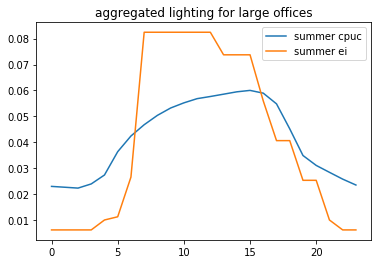

In [20]:
    plt.figure()
    df = cpuc_large
    df_ave = df.loc[~df['weekend']].groupby([ 'month','hour']).agg({'lighting':'mean' }).reset_index()
    df_tot_s = get_tot_data(df_ave, season = summer, hour_field = 'hour', energy_field = 'lighting')
    df_tot_w = get_tot_data(df_ave, season = winter, hour_field = 'hour', energy_field = 'lighting')
    dfei = ei_large
    dfei_ave = dfei.loc[~dfei['weekend']].groupby([ 'month','hour']).agg({'lighting':'mean' }).reset_index()
    dfei_tot_s = get_tot_data(dfei_ave, season = summer, hour_field = 'hour', energy_field = 'lighting')
    dfei_tot_w = get_tot_data(dfei_ave, season = winter, hour_field = 'hour', energy_field = 'lighting')
    #dfC8_ave = dfC8760.loc[~dfC8760['weekend']].groupby([ 'month','hour']).agg({'IntLight':'mean' }).reset_index()
    #dfC_tot_s_light = get_tot_data(dfC8_ave, season = summer, hour_field = 'hour', energy_field = 'IntLight')
    df_tot_s.plot(label = 'summer cpuc')
    dfei_tot_s.plot(label = 'summer ei')
    #dfC_tot_s_light.plot(label = 'summer CEUS')
    plt.legend(loc='best')
    plt.title('aggregated lighting for large offices')

Text(0.5, 1.0, 'aggregated hvac for large offices')

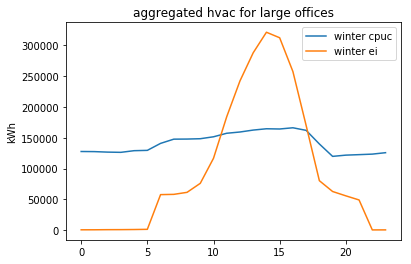

In [21]:
    plt.figure()
    df = cpuc_large
    df_ave = df.loc[~df['weekend']].groupby([ 'month','hour']).agg({'hvac':'mean' }).reset_index()
    df_tot_s = get_tot_data_sum(df_ave, season = summer, hour_field = 'hour', energy_field = 'hvac')
    df_tot_w = get_tot_data_sum(df_ave, season = winter, hour_field = 'hour', energy_field = 'hvac')
    dfei = ei_large
    dfei_ave = dfei.loc[~dfei['weekend']].groupby([ 'month','hour']).agg({'hvac':'mean' }).reset_index()
    dfei_tot_s = get_tot_data_sum(dfei_ave, season = summer, hour_field = 'hour', energy_field = 'hvac')
    dfei_tot_w = get_tot_data_sum(dfei_ave, season = winter, hour_field = 'hour', energy_field = 'hvac')
    df_tot_w.plot(label = 'winter cpuc')
    dfei_tot_w.plot(label = 'winter ei')
    plt.legend(loc='best')
    plt.ylabel('kWh')
    plt.title('aggregated hvac for large offices')

Text(0.5, 1.0, 'aggregated lighting for medium offices')

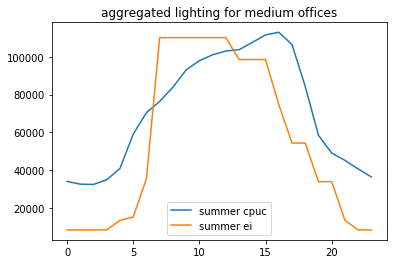

In [22]:
    plt.figure()
    df = cpuc_med
    df_ave = df.loc[~df['weekend']].groupby([ 'month','hour']).agg({'lighting':'mean' }).reset_index()
    df_tot_s = get_tot_data_sum(df_ave, season = summer, hour_field = 'hour', energy_field = 'lighting')
    df_tot_w = get_tot_data(df_ave, season = winter, hour_field = 'hour', energy_field = 'lighting')
    dfei = ei_med
    dfei_ave = dfei.loc[~dfei['weekend']].groupby([ 'month','hour']).agg({'lighting':'mean' }).reset_index()
    dfei_tot_s = get_tot_data_sum(dfei_ave, season = summer, hour_field = 'hour', energy_field = 'lighting')
    dfei_tot_w = get_tot_data(dfei_ave, season = winter, hour_field = 'hour', energy_field = 'lighting')
    df_tot_s.plot(label = 'summer cpuc')
    dfei_tot_s.plot(label = 'summer ei')
    plt.legend(loc='best')
    plt.title('aggregated lighting for medium offices')

Text(0.5, 1.0, 'aggregated hvac for medium offices')

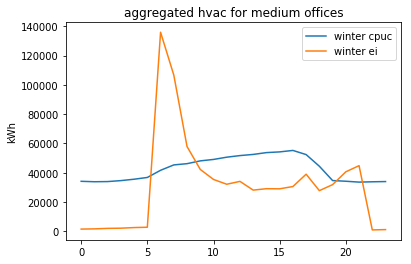

In [23]:
    plt.figure()
    df = cpuc_med
    df_ave = df.loc[~df['weekend']].groupby([ 'month','hour']).agg({'hvac':'mean' }).reset_index()
    df_tot_s = get_tot_data_sum(df_ave, season = summer, hour_field = 'hour', energy_field = 'hvac')
    df_tot_w = get_tot_data_sum(df_ave, season = winter, hour_field = 'hour', energy_field = 'hvac')
    dfei = ei_med
    dfei_ave = dfei.loc[~dfei['weekend']].groupby([ 'month','hour']).agg({'hvac':'mean' }).reset_index()
    dfei_tot_s = get_tot_data_sum(dfei_ave, season = summer, hour_field = 'hour', energy_field = 'hvac')
    dfei_tot_w = get_tot_data_sum(dfei_ave, season = winter, hour_field = 'hour', energy_field = 'hvac')
    df_tot_w.plot(label = 'winter cpuc')
    dfei_tot_w.plot(label = 'winter ei')
    plt.ylabel('kWh')
    plt.legend(loc='best')
    plt.title('aggregated hvac for medium offices')

Text(0.5, 1.0, 'aggregated hvac for small offices')

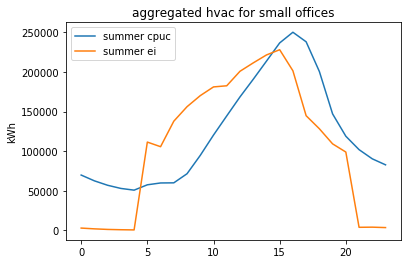

In [24]:
    plt.figure()
    df = cpuc_small
    df_ave = df.loc[~df['weekend']].groupby([ 'month','hour']).agg({'hvac':'mean' }).reset_index()
    df_tot_s = get_tot_data_sum(df_ave, season = summer, hour_field = 'hour', energy_field = 'hvac')
    df_tot_w = get_tot_data(df_ave, season = winter, hour_field = 'hour', energy_field = 'hvac')
    dfei = ei_small
    dfei_ave = dfei.loc[~dfei['weekend']].groupby([ 'month','hour']).agg({'hvac':'mean' }).reset_index()
    dfei_tot_s = get_tot_data_sum(dfei_ave, season = summer, hour_field = 'hour', energy_field = 'hvac')
    dfei_tot_w = get_tot_data(dfei_ave, season = winter, hour_field = 'hour', energy_field = 'hvac')
    df_tot_s.plot(label = 'summer cpuc')
    dfei_tot_s.plot(label = 'summer ei')
    plt.ylabel('kWh')
    plt.legend(loc='best')
    plt.title('aggregated hvac for small offices')
    

Text(0.5, 1.0, 'aggregated lighting for small offices')

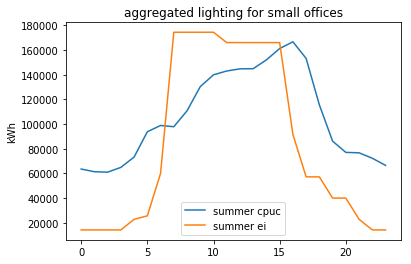

In [25]:
    plt.figure()
    df = cpuc_small
    df_ave = df.loc[~df['weekend']].groupby([ 'month','hour']).agg({'lighting':'mean' }).reset_index()
    df_tot_s = get_tot_data_sum(df_ave, season = summer, hour_field = 'hour', energy_field = 'lighting')
    df_tot_w = get_tot_data(df_ave, season = winter, hour_field = 'hour', energy_field = 'lighting')
    dfei = ei_small
    dfei_ave = dfei.loc[~dfei['weekend']].groupby([ 'month','hour']).agg({'lighting':'mean' }).reset_index()
    dfei_tot_s = get_tot_data_sum(dfei_ave, season = summer, hour_field = 'hour', energy_field = 'lighting')
    dfei_tot_w = get_tot_data(dfei_ave, season = winter, hour_field = 'hour', energy_field = 'lighting')
    df_tot_s.plot(label = 'summer cpuc')
    dfei_tot_s.plot(label = 'summer ei')
    plt.ylabel('kWh')
    plt.legend(loc='best')
    plt.title('aggregated lighting for small offices')

In [26]:
ei_compare = pd.DataFrame({'sl':ei_small['lighting'], 'ml':ei_med['lighting'],'bl':ei_large['lighting'],'sh':ei_small['hvac'], 'mh':ei_med['hvac'],'bh':ei_large['hvac']})

# Incorporate all potential matches from zip code

If one wished to do more extensive Open EI matching one could use this instead. However, it is certainly not considered essential. 

In [27]:
#Now do this for every city
zmapf = zipmap[['sublap', 'city']].copy()
#just use the first in every group for now
zmapf['sublap'] = zmapf['sublap'].str.slice(5,9)
#make a dic for easy lookup
zmapdic = dict(zip(zmapf.sublap,zmapf.city))
#the missing two sublaps
#['SLAP_PGP2-APND', 'SLAP_PGSF-APND']


In [28]:
#Do large office for open ei
ei_sl_8760_large_office = {}
data_direi = r'G:\Shared Drives\BTO Topic 2  Integrating EE & DR\Task 2\Load_Shape_Data\OPEN_EI\*'
#set the city of interest
for sl in list(cpuc_sl_8760_large_office.keys()):
    #loop through every potential city
    dirlist = []
    for city in zmapf.loc[zmapf['sublap']==sl,'city']:
        #get to the appropriate directory
        files = glob.glob(data_direi)
        file = [file for file in files if city in file]
        files = glob.glob(str(file[0] + '\*'))
        #Do the first one
        fname =  'LargeOffice'
        dirs = [file for file in files if fname in file]
        #create a list of all directories for cities in the sublap
        dirlist.append(dirs[0])
    agg_ei = pd.read_csv(dirlist[0])
    agg_ei['hvac'] = agg_ei['Cooling:Electricity [kW](Hourly)'] + agg_ei['Heating:Electricity [kW](Hourly)'] + agg_ei['Fans:Electricity [kW](Hourly)']
    agg_ei.rename({'InteriorLights:Electricity [kW](Hourly)':'lighting'}, inplace=True, axis=1)
    if (len(dirlist)>1):
        for i in range(1, len(dirlist)):
            agg_ei_building = pd.read_csv(dirs[0])
            agg_ei_building['hvac'] = agg_ei_building['Cooling:Electricity [kW](Hourly)'] + agg_ei_building['Heating:Electricity [kW](Hourly)'] + agg_ei_building['Fans:Electricity [kW](Hourly)']
            agg_ei_building.rename({'InteriorLights:Electricity [kW](Hourly)':'lighting'}, inplace=True, axis=1)
            agg_ei =  agg_ei.add(agg_ei_building, fill_value=0)
    #scale down to 1 'average' building
    agg_ei[['lighting','hvac']] = agg_ei[['lighting','hvac']]/len(dirlist)
    hourfield = 'hour'
    year = 2004
    agg_ei = agg_ei.reset_index().rename({'index':'hour'}, axis=1)
    agg_ei['hour'] = agg_ei['hour']+1
    agg_ei['hour'] = agg_ei['hour'].astype(float)
    agg_ei['day_of_year'] = np.ceil(agg_ei[hourfield]/24).astype(int)
    dt = datetime.datetime(year,1,1,0,0)
    agg_ei['date'] = dt
    for ind in agg_ei.index:
        hours=agg_ei.loc[ind, hourfield]-1
        dtdelta = datetime.timedelta(hours = hours)
        agg_ei.loc[ind,'date'] = dt+dtdelta
    agg_ei['month'] = agg_ei['date'].dt.month        
    agg_ei.drop('Date/Time', axis=1, inplace=True)
    agg_ei['weekend'] = agg_ei['date'].dt.weekday>4
    agg_ei['hour'] = agg_ei['date'].dt.hour
    ei_sl_8760_large_office[sl] = agg_ei

In [29]:
#build a custom smoothing function to fix the zeroed edges
def smooth_it(df,field, timewindow = [9,17], window_size=13, sd = 4):
    newfield = 'smoothed_' +field 
    #
    window_size 
    df[newfield] = df[field].rolling(window_size, center=True, min_periods=0, win_type='gaussian').mean(std=sd)
    df.loc[(df['hour']<timewindow[0])|(df['hour']>timewindow[1]),field] = df.loc[(df['hour']<timewindow[0])|(df['hour']>timewindow[1]),newfield]
    return df    

#### Do a quick comparison to what the total load for commercial buildings actually is compared to our scaled numbers

In [30]:
#Sanity check
#36,000 GW is the commercial total in PG&E
cpuc_small.hvac.sum() + cpuc_med.hvac.sum() + cpuc_large.hvac.sum()+cpuc_small.lighting.sum() + cpuc_med.lighting.sum() + cpuc_large.lighting.sum()
#5,626 GW from cpuc hvac and lighting
ei_small.hvac.sum() + ei_med.hvac.sum() + ei_large.hvac.sum()+ei_small.lighting.sum() + ei_med.lighting.sum() + ei_large.lighting.sum()
#4,950 GW from Open EI scaled

4949807896.628969

In [31]:
ind = ['small_hvac', 'med_hvac', 'large_hvac','small_light', 'med_light', 'large_light', 'total']
sanity_check = pd.DataFrame({'cpuc':[cpuc_small.hvac.sum(), cpuc_med.hvac.sum(), cpuc_large.hvac.sum(),cpuc_small.lighting.sum() , cpuc_med.lighting.sum(), cpuc_large.lighting.sum(),cpuc_small.hvac.sum() + cpuc_med.hvac.sum() + cpuc_large.hvac.sum()+cpuc_small.lighting.sum() + cpuc_med.lighting.sum() + cpuc_large.lighting.sum()], 'ei':[ei_small.hvac.sum(),ei_med.hvac.sum(),ei_large.hvac.sum(),ei_small.lighting.sum(),ei_med.lighting.sum(),ei_large.lighting.sum(),ei_small.hvac.sum() + ei_med.hvac.sum() + ei_large.hvac.sum()+ei_small.lighting.sum() + ei_med.lighting.sum() + ei_large.lighting.sum()]}, index = ind)
sanity_check


cpuc            ei
small_hvac   7.243771e+08  7.361674e+08
med_hvac     4.792855e+08  4.585698e+08
large_hvac   1.334453e+09  1.083416e+09
small_light  8.445818e+08  8.051350e+08
med_light    5.427025e+08  5.189115e+08
large_light  1.700574e+09  1.347608e+09
total        5.625973e+09  4.949808e+09

This is a customized smoothing function. The selected scaling was a trial and error process that led to this semi optimized smoother. It accounts for the uncertainty in use and occupancy for the open ei building. 

In [32]:
def custom_roll(df, field ='hvac', wind_size = np.repeat([5,5,3,2,3,1,0,0,0,3,5,5],2)):
    '''
    This function takes a data frame and smooths its elements. 
    Note the window size for any element cannot exceed the bound of the 
    data field (ie element 2 cannot have a smooth of 3)
    '''
    wind_dic = dict(zip(df['hour'], wind_size))
    roll_list = []
    first = df.loc[0:wind_dic[0],field].mean()
    roll_list.append(first)
    for i in range(1,len(df)-1):
        roll_size = wind_dic[df.loc[i,'hour']]
        element = df.loc[i-roll_size:i+roll_size, field].mean()
        roll_list.append(element)
    last = df.loc[len(df)-1:len(df), field].mean()
    roll_list.append(last)
    df[str('rolled '+field)] = roll_list
    return df


Text(0.5, 1.0, 'aggregated lighting for small offices')

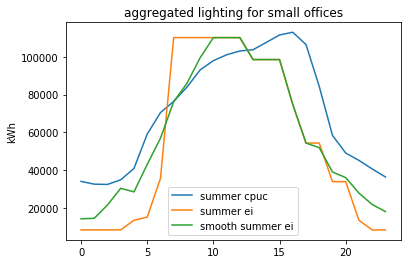

In [33]:
    plt.figure()
    df = cpuc_med
    df_ave = df.loc[~df['weekend']].groupby([ 'month','hour']).agg({'lighting':'mean' }).reset_index()
    df_tot_s = get_tot_data_sum(df_ave, season = summer, hour_field = 'hour', energy_field = 'lighting')
    df_tot_w = get_tot_data(df_ave, season = winter, hour_field = 'hour', energy_field = 'lighting')
    dfei = ei_med
    dfei_ave = dfei.loc[~dfei['weekend']].groupby([ 'month','hour']).agg({'lighting':'mean' }).reset_index()
    smoothie = custom_roll(dfei_ave, field='lighting')
    dfei_tot_s = get_tot_data_sum(dfei_ave, season = summer, hour_field = 'hour', energy_field = 'lighting')
    dfei_tot_smooth = get_tot_data_sum(smoothie, season = summer, hour_field = 'hour', energy_field = 'rolled lighting')
    dfei_tot_w = get_tot_data(dfei_ave, season = winter, hour_field = 'hour', energy_field = 'lighting')
    df_tot_s.plot(label = 'summer cpuc')
    dfei_tot_s.plot(label = 'summer ei')
    dfei_tot_smooth.plot(label = 'smooth summer ei')
    plt.ylabel('kWh')
    plt.legend(loc='best')
    plt.title('aggregated lighting for small offices')

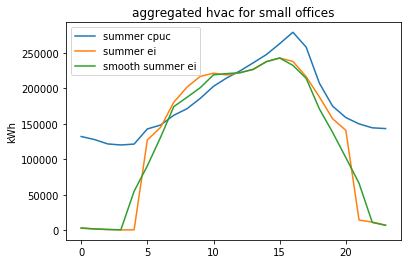

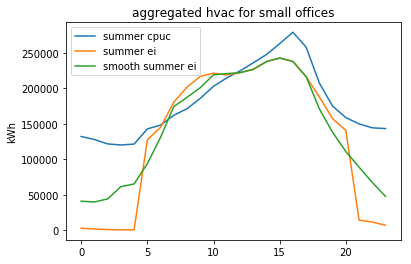

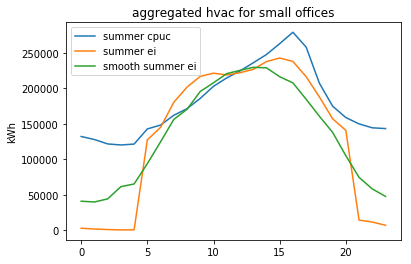

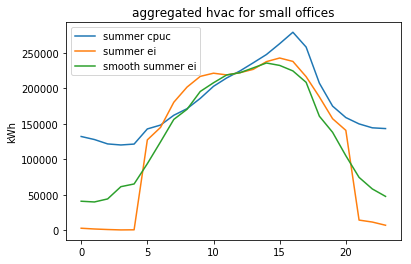

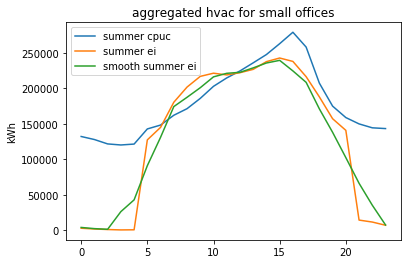

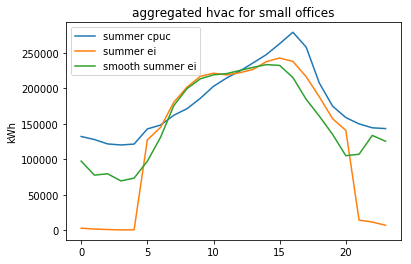

In [35]:
x4 = list(round(df_tot_s/dfei_tot_s))
x0 = np.repeat([1,1,2,2,3,1,0,0,1,3,2,1],2)
x1 =[5,5,5,5,3,3,3,3,4,4,4,3,2,2,3,4,4,4,4,3,3,3,4,5]
x2 =[5,5,5,5,3,3,3,3,4,4,4,0,0,1,1,2,2,2,4,3,3,3,4,5]
x3 = np.repeat([2,2,1,2,3,2,1,1,2,3,2,2],2)
xp = np.repeat([5,5,3,2,3,1,0,0,0,3,5,5],2)
winds = [x0,xp,x1,x2,x3,x4]
for wind in winds:
    plt.figure()
    df = cpuc_large
    df_ave = df.loc[~df['weekend']].groupby([ 'month','hour']).agg({'hvac':'mean' }).reset_index()
    df_tot_s = get_tot_data_sum(df_ave, season = summer, hour_field = 'hour', energy_field = 'hvac')
    df_tot_w = get_tot_data(df_ave, season = winter, hour_field = 'hour', energy_field = 'hvac')
    dfei = ei_large
    dfei_ave = dfei.loc[~dfei['weekend']].groupby([ 'month','hour']).agg({'hvac':'mean' }).reset_index()
    smoothie = custom_roll(dfei_ave, field='hvac', wind_size =wind)
    dfei_tot_s = get_tot_data_sum(dfei_ave, season = summer, hour_field = 'hour', energy_field = 'hvac')
    dfei_tot_smooth = get_tot_data_sum(smoothie, season = summer, hour_field = 'hour', energy_field = 'rolled hvac')
    dfei_tot_w = get_tot_data(dfei_ave, season = winter, hour_field = 'hour', energy_field = 'hvac')
    df_tot_s.plot(label = 'summer cpuc')
    dfei_tot_s.plot(label = 'summer ei')
    dfei_tot_smooth.plot(label = 'smooth summer ei')
    plt.ylabel('kWh')
    plt.legend(loc='best')
    plt.title('aggregated hvac for small offices')

Text(0.5, 1.0, 'aggregated hvac for small offices')

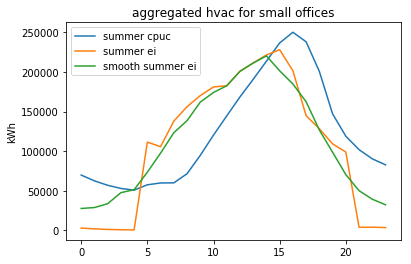

In [36]:
    plt.figure()
    df = cpuc_small
    df_ave = df.loc[~df['weekend']].groupby([ 'month','hour']).agg({'hvac':'mean' }).reset_index()
    df_tot_s = get_tot_data_sum(df_ave, season = summer, hour_field = 'hour', energy_field = 'hvac')
    df_tot_w = get_tot_data(df_ave, season = winter, hour_field = 'hour', energy_field = 'hvac')
    dfei = ei_small
    dfei_ave = dfei.loc[~dfei['weekend']].groupby([ 'month','hour']).agg({'hvac':'mean' }).reset_index()
    smoothie = custom_roll(dfei_ave, field='hvac', wind_size =x2)
    dfei_tot_s = get_tot_data_sum(dfei_ave, season = summer, hour_field = 'hour', energy_field = 'hvac')
    dfei_tot_smooth = get_tot_data_sum(smoothie, season = summer, hour_field = 'hour', energy_field = 'rolled hvac')
    dfei_tot_w = get_tot_data(dfei_ave, season = winter, hour_field = 'hour', energy_field = 'hvac')
    df_tot_s.plot(label = 'summer cpuc')
    dfei_tot_s.plot(label = 'summer ei')
    dfei_tot_smooth.plot(label = 'smooth summer ei')
    plt.ylabel('kWh')
    plt.legend(loc='best')
    plt.title('aggregated hvac for small offices')